In [12]:
%matplotlib inline

In [2]:
from selenium.webdriver.firefox.options import Options
from selenium.webdriver import FirefoxProfile
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from IPython.core.debugger import set_trace

import os, time, random
import pandas as pd
import json
import re
from datetime import timedelta, date
import requests
import traceback
import urllib.parse as urlparse
from urllib.parse import parse_qs, urlparse, urlencode, urlunparse, quote_plus
import hashlib
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

import cv2, base64
import numpy as np
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.common.action_chains import ActionChains
import math

In [3]:
DIRECTORY = "/home/keshev/Repos"
PROJECT = "AI_Scraper"

## Selenium Helper Functions

In [9]:
def initialize_browser(headless=False):
    with open(f"{DIRECTORY}/{PROJECT}/config/proxies.json", "r") as f:
        proxy_dict = json.load(f)
        proxy_list = proxy_dict["proxies"]
    #options = Options()

    #if self._worker_settings.fox_options['headless']:
    #	options.add_argument('--headless')
    # 
    profile = FirefoxProfile()
    #profile.set_preference("network.proxy.type", 1)
    #profile.set_preference("network.proxy.http", ip)
    #profile.set_preference("network.proxy.http_port", port)

    #profile.set_preference("network.proxy.ssl", ip)
    #profile.set_preference("network.proxy.ssl_port", port)

    options = Options()
    options.headless = headless
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-extensions')
    browser = webdriver.Firefox(firefox_profile=profile, options=options)
    #browser = webdriver.Firefox(firefox_profile=profile)
    return browser

def handle_init_row(site_name, site_module, scrape_id, sample_url):
    save_folder = f"{base_dir}/page_ai_init/init_page_output/{scrape_id}"
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
        
    browser = initialize_browser(headless=True)
    browser.get(sample_url)
    time.sleep(1)
    browser.execute_script(("window.scrollBy(0,document.body.scrollHeight);"))
    
    with open(f'{save_folder}/sample_page_latest.html', 'w') as f:
        html = browser.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
        f.write(browser.page_source)

    with open(f'{save_folder}/sample_page_{str(date.today()).replace("-","_") }.html', 'w') as f:
        html = browser.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
        f.write(browser.page_source)
        
    print(f"SAVING SAMPLE PAGE SOURCE FOR {site_name} {site_module} with SCRAPEID: {scrape_id}")

## Screenshot Helper Functions

In [6]:
def scroll_shim(passed_in_driver, element):
    x = element.location['x']
    y = element.location['y']
    scroll_by_coord = 'window.scrollTo(%s,%s);' % (
        x,
        y
    )
    scroll_nav_out_of_way = 'window.scrollBy(0, -120);'
    passed_in_driver.execute_script(scroll_by_coord)
    passed_in_driver.execute_script(scroll_nav_out_of_way)
    
def img_from_b64(encoded_data):
   #encoded_data = uri.split(',')[1]
   nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)
   img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
   return img

def visualize_image(img_array): 
    fig2 = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
    ax3 = fig2.add_subplot(111)
    ax3.imshow(img_array, interpolation='none')

In [24]:
def generate_sliding_window_data(browser, element, single_psource_save_path):
    #For a given webpage that browser is currently on
    #We have isolated element as our pagination element
    #We're going to then save that in the save path where for each candidate + url combo
    #we have our own folder
    '''Directory looks like this:
        amzn-best-sellers
            candidate
                candidate + url
                    screenshots
                        scroll_at_y1_metadata_file
                        scroll_at_y1_screenshot
                        scroll_at_y1_bounding_box_screenshot
                        scroll_at_y2_metadata_file
                        scroll_at_y2_screenshot
                        scroll_at_y2_bounding_box_screenshot'''
        
    #####get the bounding box 
    bounding_box = get_element_bounding_box(browser, element)
    
    bounding_box_viewport = bounding_box.copy()
    #scroll to the top
    
    height = browser.execute_script("return document.body.scrollHeight")
    window_height = browser.execute_script("return window.innerHeight")
    #Note standardize window height to avoid normalization later? 
    #Maybe but probably have to do it later anyway
    
    #scroll to the top
    browser.execute_script("window.scrollTo(0,0)")
    current_y = 0
    
    window_image_list = []
    bounding_box_image_list = []
    #autodetermine step size based on browser window height
    step_size =math.floor(0.75*window_height)
    while current_y < height: 
        #while condition sets when to stop
        #if condition handles the last acceptable range without throwing the scroll too far error
#         if (current_y + window_height)>=height:
#             #scroll up (current_y + window_height - height)
#             browser.execute_script(f"window.scrollBy(0,{-1*(current_y + window_height - height)})");
        



        
        scroll = browser.execute_script("return window.scrollY;")
        y_rel_to_viewport = bounding_box["top"] - scroll        
        #y_rel_to_viewport = y - scroll
        bounding_box_viewport["top"] = math.floor(y_rel_to_viewport)
        
        #top = document.execute_script("return (window.pageYOffset || doc.scrollTop)  - (doc.clientTop || 0)")";
        bottom = current_y + window_height

        window_screenshot, bounding_box_screenshot, metadata_dictionary = execute_screenshot_function(browser, element, bounding_box)
        window_image_list.append(window_screenshot)
        bounding_box_image_list.append(bounding_box_screenshot)

#         with open(metadata_save_path, "w") as metadata_file: 
#             json.dump(metadata_dictionary, metadata_file,indent=1)

        #TODO evalutate image and baseline psource model
        #TODO implement the execute
        #execute_codedata_function(browser, element, bounding_box_viewport)
        current_y += step_size
        browser.execute_script(f"window.scrollBy(0,{step_size})");
        
    full_browser_image = np.concatenate(window_image_list, axis=0)
    full_bounding_box_image = np.concatenate(bounding_box_image_list, axis=0)
    
    window_save_path = f"{single_psource_save_path}/window_screenshot.png"
    bounding_box_save_path = f"{single_psource_save_path}/bounding_box_screenshot.png"
    metadata_save_path = f"{single_psource_save_path}/scroll_at_{current_y}_single_screen_metadata.json" 
    
    cv2.imwrite(window_save_path, full_browser_image)
    cv2.imwrite(bounding_box_save_path, full_bounding_box_image)


In [12]:
browser = initialize_browser() 

In [13]:
base_dir = "/home/keshev/Projects/ai_scraper/"

In [14]:
initialization_samples = pd.read_csv("/home//keshev/Projects/ai_scraper/page_ai_init/sample_urls/sample_urls_latest.csv")
for i,row in initialization_samples.iterrows():
    handle_init_row(**row.to_dict())
    

SAVING SAMPLE PAGE SOURCE FOR amazon best_sellers with SCRAPEID: amzn_best_sellers
SAVING SAMPLE PAGE SOURCE FOR amazon category with SCRAPEID: amzn_category
SAVING SAMPLE PAGE SOURCE FOR indeed jobs with SCRAPEID: indeed_jobs


In [15]:
scrape_id = "amzn_best_seller"
row = initialization_samples.loc[0]
save_folder = f"{base_dir}/page_ai_init/init_page_output/{scrape_id}"
sample_url = row["sample_url"]
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

browser = initialize_browser(headless=False)
browser.get(sample_url)
time.sleep(1)
browser.execute_script(("window.scrollBy(0,document.body.scrollHeight);"))

In [16]:
height = browser.execute_script("return document.body.scrollHeight")
height

7614

In [19]:
p_finder = PaginationFinder()
candidates = p_finder.find_pagination_attributes(BeautifulSoup(browser.page_source))

In [20]:
candidates

{'67ed896d9f75fa04d949158d4aa2692e': {'element_attributes': {'href': 'https://www.amazon.ca/Best-Sellers-Home-Kitchen/zgbs/kitchen/ref=zg_bs_pg_1/134-1009487-8837928?_encoding=UTF8&pg=1'},
  'xpath': '/html/body/div[2]/div[2]/div/div/div[1]/div/div[2]/div/ul/li[2]/a',
  'element_text': '←Previous Page12Next page→',
  'parent_attributes': {'parent_class': 'a-pagination'},
  'parent_xpath': '/html/body/div[2]/div[2]/div/div/div[1]/div/div[2]/div/ul',
  'parent_text': '←Previous Page12Next page→',
  'grandparent_xpath': '/html/body/div[2]/div[2]/div/div/div[1]/div/div[2]/div',
  'great_grandparent_xpath': '/html/body/div[2]/div[2]/div/div/div[1]/div/div[2]'},
 'f6684c8470885aee3f257915ddf555e2': {'element_attributes': {'href': 'https://www.amazon.ca/Best-Sellers-Home-Kitchen/zgbs/kitchen/ref=zg_bs_pg_2/134-1009487-8837928?_encoding=UTF8&pg=2'},
  'xpath': '/html/body/div[2]/div[2]/div/div/div[1]/div/div[2]/div/ul/li[3]/a',
  'element_text': '←Previous Page12Next page→',
  'parent_attribut

In [73]:
candidate = browser.find_element_by_xpath(candidates["67ed896d9f75fa04d949158d4aa2692e"]["xpath"])

In [61]:
bounding_box = get_element_bounding_box(browser, candidate)

In [29]:
full,bb,meta = execute_screenshot_function(browser, candidate, bounding_box)

<ipython-input-16-571d40960e0c>:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)


In [25]:

####TODO NEXT save a useful metadata file 
    #considerations
        #Has a next pagination
        #value of window height used
        #(check if np array has an entry for each pixel)
        #the bounding box
        
####TODO NEXT Generate sliding window data for all candidates
####TODO NEXT NEXT generate sliding window data for all scrape_ids
####TODO NEXT X3 label
####TODO NEXT X4 get for other urls


#think about running the inference on just one giant image
create_single_candidate_url_train_data(browser, scrape_id, "67ed896d9f75fa04d949158d4aa2692e", candidates["67ed896d9f75fa04d949158d4aa2692e"])

<ipython-input-6-a8c4e27522ff>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)


In [59]:
####Save parent element bounding box
####attach each of those filepaths to the candidate JSON 
####find the nextiness next page

In [22]:
def execute_codedata_function(browser, element, bounding_box): 
    #NOTES
    #save "visible page source" by iterating through all the elements WebElement.isDisplayed()
    #check if the element I want is displayed
    #is the element on screen? (does that actually matter so long as I can find it in the page source?)
        #Doesn't matter - metadata grab is actually just going to operate on the rendered page script
    
    ############################################################################
    #Let's keep it simple for now. One algorith running on the full page source#
    ############################################################################
    
    #save the element string
    #save the 
    pass

def execute_screenshot_function(browser, element, bounding_box): 
    ####can grab whatever I need out of the full page source later
    current_y = browser.execute_script("var doc = document.documentElement;return (window.pageYOffset || doc.scrollTop)  - (doc.clientTop || 0)")
    #top of the browser window
    window_height = browser.execute_script("return window.innerHeight")
    bottom = current_y + browser.execute_script("return window.innerHeight")
    #bottom of the browser window
    
    scroll = browser.execute_script("return window.scrollY;")
    src_base64 = browser.get_screenshot_as_base64()
    full_screen_img = img_from_b64(src_base64)
    bounding_box_img = full_screen_img.copy()
    top_rel_to_viewport =  bounding_box["top"] - scroll
    
    #scr_img = Image(blob=scr_png)
    
    if current_y < bounding_box["top"] and (bottom) > (bounding_box["top"] + bounding_box["height"]):
        #bounding_box is in frame

        x1,y1,x2,y2 = bounding_box["left"],\
                      top_rel_to_viewport,\
                      bounding_box["left"] + bounding_box["width"],\
                      top_rel_to_viewport + bounding_box["height"]
        cv2.rectangle(bounding_box_img,(x1,y1),(x2,y2),(0,255,0),6)
        match_type = "full"
    elif current_y > (bounding_box["top"] - window_height) and current_y < bounding_box["top"]:
        #bounding box is partially in frame cut off at the bottom
        x1,y1,x2,y2 = bounding_box["left"],\
                      top_rel_to_viewport,\
                      bounding_box["left"] + bounding_box["width"],\
                      bottom
        cv2.rectangle(bounding_box_img,(x1,y1),(x2,y2),(255,0,0),1)
        match_type = "partial"
    elif current_y < (bounding_box["top"] + bounding_box["height"]) and current_y > bounding_box["top"]:
        #bounding box is partially in frame cut off at the top
        x1,y1,x2,y2 = bounding_box["left"],\
              current_y,\
              bounding_box["left"] + bounding_box["width"],\
              top_rel_to_viewport + bounding_box["height"]
        cv2.rectangle(bounding_box_img,(x1,y1),(x2,y2),(0,255,0),6)
        match_type = "partial"
    else: 
        #bounding box is not in frame    
        match_type = "none"
        x1,y1,x2,y2 = -1,-1,-1,-1

    metadata_dictionary = {'bounding_box':[(x1,y1),(x2,y2)],
                           'window_top_px':current_y,
                           'window_height':window_height, 
                           'match_type':match_type}
    #save a 'label' file with:
        #bounding box relative to the viewport
        #whether the element is visible / partially visible / not visible
        #use WebElement.isDisplayed()
        
    #take a screenshot
    #save the screeenshot
    
    return full_screen_img, bounding_box_img, metadata_dictionary

def get_element_bounding_box(browser, element: WebElement):
    
    #only handles the vertical scroll case
    scrollY = browser.execute_script("return window.scrollY;")
    scrollX = browser.execute_script("return window.scrollX")
    
    #scroll to the element
    scroll_shim(browser, element)
    
    #move the cursor to the element
    ActionChains(browser).move_to_element(element).perform()  # focus

    #get all the bounding box information
    x = element.location["x"]
    y = element.location["y"]
    #y_rel_to_viewport = y - scroll
    
    w = element.size["width"]
    h = element.size["height"]
    
    bounding_box = {"left":math.floor(x),\
                    "top":math.floor(y),\
                    "width":math.ceil(w),\
                    "height":math.ceil(h)\
                   }
    
    #set the browser back to where it was before
    browser.execute_script(f"window.scrollTo({scrollX}, {scrollY});")
    
    return bounding_box
    
def get_element_screenshot(element: WebElement) -> bytes:    
    
    driver = element._parent
    ActionChains(driver).move_to_element(element).perform()  # focus
    src_base64 = driver.get_screenshot_as_base64()
    scr_png = b64decode(src_base64)
    scr_img = Image(blob=scr_png)
    #TODO better structure these 2 functions so they work better independently
    scroll = browser.execute_script("return window.scrollY;")

    bounding_box = get_element_bounding_box(element, scroll)
    set_trace()        

    scr_img.crop(**bounding_box)
#     scr_img.crop(
#         left=math.floor(x),
#         top=math.floor(y),
#         width=math.ceil(w),
#         height=math.ceil(h),
#     )
    return scr_img.make_blob(), bounding_box

def create_single_candidate_url_train_data(browser, scrape_id, candidate_key, candidate_info): 
    #make all the directories
    base_dir = f"/home/keshev/Projects/ai_scraper/page_ai_init/init_page_output/{scrape_id}/screenshots"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        
    candidate_dir = f"{base_dir}/{candidate_key}"
    if not os.path.exists(candidate_dir):
        os.mkdir(candidate_dir)
        
    psource_unique_directory_key = hashlib.md5((candidate_key + browser.current_url).encode("utf-8")).hexdigest()
    psource_unique_directory_path = f"{candidate_dir}/{psource_unique_directory_key}"
    if not os.path.exists(psource_unique_directory_path):
        os.mkdir(psource_unique_directory_path)
    
    element = browser.find_element_by_xpath(candidate_info["xpath"])
    generate_sliding_window_data(browser, element, psource_unique_directory_path)


#     bounding_box_dir = f"{sub_directory_path}/drawn_bounding_box"
#     cropped_img_dir = f"{sub_directory_path}/cropped_image_dir"
#     if not os.path.exists(bounding_box_dir):
#         os.mkdir(bounding_box_dir)
#     if not os.path.exists(cropped_img_dir):
#         os.mkdir(cropped_img_dir)
    
#     #make all the directories

#         fname = hashlib.md5(element_xpath.encode("utf-8")).hexdigest()
#         entry = {"file_key":fname,\
#                  "file_path":f"{cropped_img_dir}/{fname}/.png",\
#                  "bounding_box":bounding_box,\
#                  "drawn_bounding_box_filepath":f"{bounding_box_dir}/{fname}/.png",\
#                  "levels_up":levels_up, \
#                  "element_xpath":element_xpath}
#     output_metadata_dictionary = {candidate_key:{sub_directory_key:metadata_dictionary}}
#     return output_metadata_dictionary
        

In [ ]:
#NOTES

#My oringial thoughts on the approach was to iterate up the xpath but I don't think I really need to do that at all
#As I look more into the xpath/dom tree route this might make sense to bring back

#     key:hash of md5 {
#         key: hash of md5 + url {
#             a. Then save a metadata file json containing the relative  path to the images
#             b. Their xpath
#             c. Their bounding boxes in the full document itself
#             d. how many levels up they were from our desired element
#             e. The candidate xpath
#             f. the candidate hash
#         }
#     }
###############################################################
########################CODE SNIPPET###########################
###############################################################


#     metadata_dictionary = {}
#     candidate_xpath = candidate_info["xpath"]
#     element_xpath = candidate_info["xpath"]
#     levels_up = 0
#     while len(element_xpath.split("/"))>=2:
#         candidate = browser.find_element_by_xpath(element_xpath)
#         image, bounding_box = get_element_screenshot(candidate)
        
#         #####TODO get the browser screenshot, draw a bounding box on it save it as well
#         #####TODO implement sliding 
        
#         fname = hashlib.md5(element_xpath.encode("utf-8")).hexdigest()
#         entry = {"file_key":fname,\
#                  "file_path":f"{cropped_img_dir}/{fname}/.png",\
#                  "bounding_box":bounding_box,\
#                  "drawn_bounding_box_filepath":f"{bounding_box_dir}/{fname}/.png",\
#                  "levels_up":levels_up, \
#                  "element_xpath":element_xpath}

#         #keep track of how many levels from actual candidate we are going
#         levels_up += 1
#         #go up one level in the xpath
#         element_xpath = '/'.join(element_xpath.split("/")[:-1])
#     output_metadata_dictionary = {candidate_key:{sub_directory_key:metadata_dictionary}}

###############################################################
########################END SNIPPET############################
###############################################################


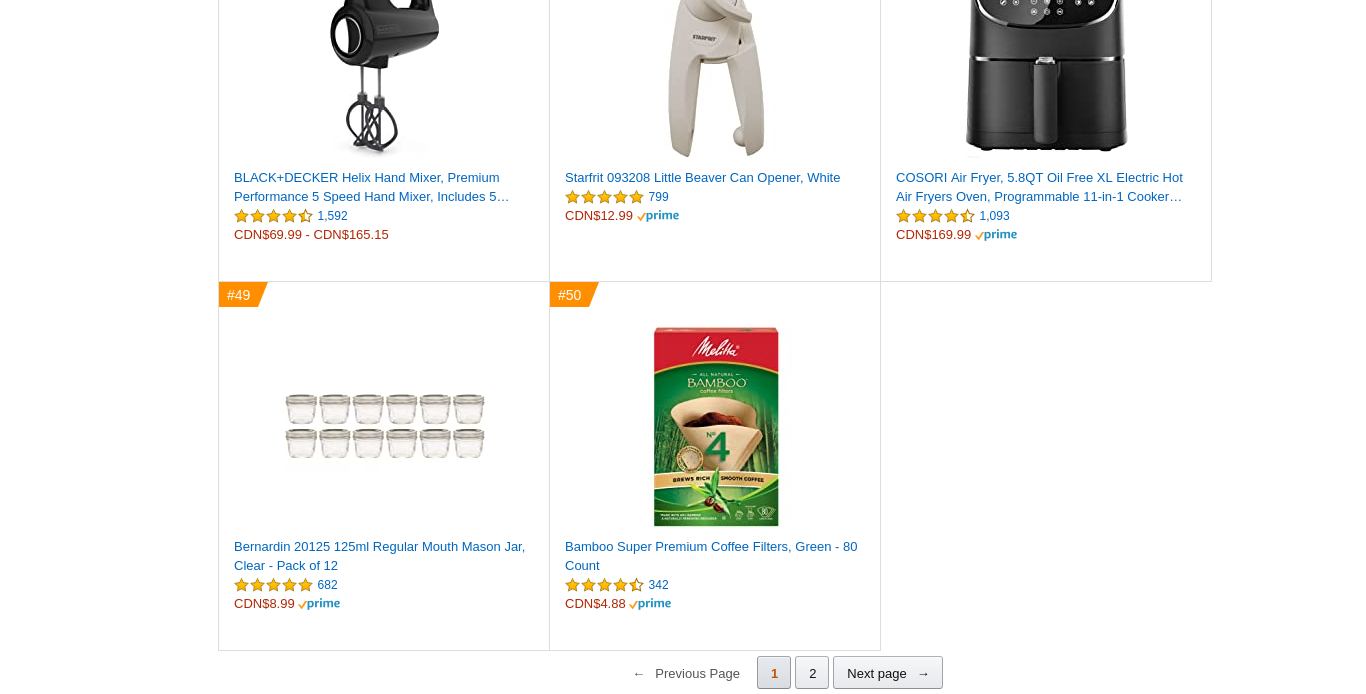

In [110]:
Image(blob=b64decode(candidate.screenshot_as_base64))

In [ ]:
############TODO 

#In sample urls folder, look for a file called sample_urls latest
#go to each of the pages render the html and save the sitemap in the init page source folder based on the save value from the csv once datestamped, another to latest
#

In [18]:
class PaginationFinder(): 
    
    def __init__(self):
        pass
    
    
    def output_pagination_attributes(self,scrape_id):
    
        soup = BeautifulSoup(open(f"{base_dir}/page_ai_init/init_page_output/{scrape_id}/sample_page_latest.html").read())
        candidates = self.find_pagination_attributes(soup)
        output_json = {scrape_id:{"candidate_list":candidates, "correct_index_value":-1}}
        if not os.path.exists(f"{base_dir}/parse_metadata/{scrape_id}"):
            os.mkdir(f"{base_dir}/parse_metadata/{scrape_id}")
        with(open(f"{base_dir}/parse_metadata/{scrape_id}/next_page_element.json", "w")) as npe_file: 
            json.dump(output_json,npe_file,indent=2)

        print(f"SUCCESSFULLY WROTE CANDIDATE FILE FOR {scrape_id}")
        #load bs4
    def xpath_soup(self,element):
        # type: (typing.Union[bs4.element.Tag, bs4.element.NavigableString]) -> str
        """
        Generate xpath from BeautifulSoup4 element.

        :param element: BeautifulSoup4 element.
        :type element: bs4.element.Tag or bs4.element.NavigableString
        :return: xpath as string
        :rtype: str

        Usage
        -----
        >>> import bs4
        >>> html = (
        ...     '<html><head><title>title</title></head>'
        ...     '<body><p>p <i>1</i></p><p>p <i>2</i></p></body></html>'
        ...     )
        >>> soup = bs4.BeautifulSoup(html, 'html.parser')
        >>> xpath_soup(soup.html.body.p.i)
        '/html/body/p[1]/i'

        >>> import bs4
        >>> xml = '<doc><elm/><elm/></doc>'
        >>> soup = bs4.BeautifulSoup(xml, 'lxml-xml')
        >>> xpath_soup(soup.doc.elm.next_sibling)
        '/doc/elm[2]'

        """
        components = []
        child = element if element.name else element.parent
        for parent in child.parents:  # type: bs4.element.Tag
            siblings = parent.find_all(child.name, recursive=False)
            components.append(
                child.name if 1 == len(siblings) else '%s[%d]' % (
                    child.name,
                    next(i for i, s in enumerate(siblings, 1) if s is child)
                    )
                )
            child = parent
        components.reverse()
        return '/%s' % '/'.join(components)
    
    def find_pagination_attributes(self,soup):
        matched_attrs = soup.find_all(lambda t: self.is_pagination_attribute(t))
        #identifying_attribute = [t.attrs for t in matched_attr]
        #possible_attributes = [{k:(v if k!="class" else v[0]) for k,v in y.items()} for y in identifying_attribute]
        new_dict = {} 
        for matched_attr in matched_attrs:
            hrefs =  self.get_all_pagination_hrefs(matched_attr)
            parent_xpath = self.xpath_soup(matched_attr)
            parent_attributes = {f"parent_{k}":(v if k!="class" else v[0]) for k,v in matched_attr.attrs.items()}
            grand_parent = self.xpath_soup(matched_attr.parent)
            great_grandparent = self.xpath_soup(matched_attr.parent.parent)
            for href in hrefs: 
                hashed_key = hashlib.md5(href.encode('utf-8')).hexdigest()
                if not new_dict.get(hashed_key):
                    new_dict[hashed_key] = {"element_attributes":{k:(v if k!="class" else v[0]) for k,v in href.attrs.items()},
                                            "xpath":self.xpath_soup(href),
                                            "element_text":matched_attr.text,
                                            "parent_attributes":parent_attributes,
                                            "parent_xpath":parent_xpath,
                                            "parent_text":matched_attr.text,
                                            "grandparent_xpath":grand_parent,
                                            "great_grandparent_xpath":great_grandparent
                                           } 

        #href_list = list(set([x for y in matched_attr for x in get_all_pagination_hrefs(y)]))
        #possible_attributes = [{"element_attributes":{k:(v if k!="class" else v[0]) for k,v in x.attrs.items()},"xpath":xpath_soup(x)} for x in href_list]

        return new_dict

    def get_all_pagination_hrefs(self,tag):
        hrefs = tag.find_all("a",attrs={"href":True})
        return hrefs


    def is_pagination_attribute(self,tag):
        id_class_search_terms = re.compile("pagination|next page|pagn", flags=re.IGNORECASE)
        #set_trace()
        for k,v in tag.attrs.items():
            try:
                if id_class_search_terms.search(k):
                    return True
                if type(v)=="list":
                    if id_class_search_terms.search(' '.join(v)):
                        return True
                else: 
                    if id_class_search_terms.search(str(v)):
                        return True
            except Exception as e:
                print(e)
                set_trace()
        return []